# Connectivity Analysis using EBRAINS Atlas

This notebook is a first shot at making a connectivity analysis pipeline using ebrains and nilearn. The pipeline will ideally contains the following steps:

- **Step 1:** Load fmri data from ebrains
- **Step 2:** Load atlas from ebrains
- Make sure everything is in the right space
- **Step 3:** Use nilearn to extract signals
- **Step 4:** Use nilearn to compute some connectivity from these signals
- **Step 5:** Use nilearn to visualize this connectivity (as a matrix, as a graph...)
- Upload the results back to ebrains
- Visualize them using the visualization tools of ebrain

## Step 1: Load fmri data

Ideally this will be loaded from EBRAINS. We have to find/upload a good dataset. 

For now, we rely on Nilearn for this.

In [1]:
# import nilearn newest version (make sure it is 0.7.1 or more)
import nilearn
nilearn.__version__

'0.7.1'

In [2]:
from nilearn.datasets import fetch_development_fmri

# One subject of brain development fmri data
data = fetch_development_fmri(n_subjects=10)

/home/nicolas/anaconda3/envs/brainscapes/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Step 2: Load atlas from ebrains

Here, we use brainscapes to load the multilevel human atlas:

In [3]:
import brainscapes as bs
bs.logger.setLevel("INFO")
atlas = bs.atlases.MULTILEVEL_HUMAN_ATLAS

List the available spaces:

In [4]:
[space.name for space in atlas.spaces]

['MNI 152 ICBM 2009c Nonlinear Asymmetric',
 'MNI Colin 27',
 'Big Brain (Histology)']

List the available parcellations:

In [5]:
[p.name for p in atlas.parcellations]

['Julich-Brain Probabilistic Cytoarchitectonic Maps (v2.5)',
 'Julich-Brain Probabilistic Cytoarchitectonic Maps (v1.18)',
 'Probabilistic Long White Matter Bundle Maps',
 'Probabilistic Superficial Fibre Bundle Maps',
 'BigBrain Isocortex Segmentation',
 'Cortical Layers Segmentation',
 'Dictionary of functional modes (64 dimensions)',
 'Dictionary of functional modes (128 dimensions)',
 'Dictionary of functional modes (256 dimensions)',
 'Dictionary of functional modes (512 dimensions)',
 'Dictionary of functional modes (1024 dimensions)']

### Use DiFuMo 64

I propose here to use Difumo 64 as this is also available through Nilearn for comparison:

In [6]:
# Select Difumo 64
atlas.select_parcellation(atlas.parcellations[6])

[brainscapes:INFO]  Selected parcellation "Dictionary of functional modes (64 dimensions)"


In [7]:
atlas.selected_parcellation.name

'Dictionary of functional modes (64 dimensions)'

<p style="color: red;"><b>BUG: The description says 128 dimensions instead of 64.</b></p>

In [8]:
atlas.selected_parcellation.description

'DiFuMo (Dictionary of Functional Modes) 128-dimensional atlas presents a parcellation of the brain into 128 elementary structures using sparse dictionary learning. The atlas contains two main components: (1) an image of the 128 spatial components, sampled in MNI space, and (2) anatomical names for these 128 regions. It is meant to serve as an atlas to extract functional signals, eg to create image-derived phenotypes. These modes are optimized to represent well raw BOLD time series, over a with range of experimental conditions.'

Get the maps in MNI 152 ICBM space (first one in `atlas.spaces`):

In [9]:
maps = atlas.get_maps(atlas.spaces[0])['whole brain']
maps.shape

(104, 123, 104)

**Question**

The maps is 3D, so I suppose the fourth dimension was reduced by taking the `arg_max` for each voxel, right?

Have a look at the label values:

In [10]:
import numpy as np
from nilearn.image import get_data
np.unique(get_data(maps))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

Have a look at the label names:

In [11]:
labels = []
for label_desc in atlas.selected_parcellation.regions:
    label_name = label_desc['name']
    label_idx = label_desc['labelIndex']
    print(f"Label index {label_idx} is '{label_name}'")
    labels.append(label_name)
assert len(labels) == len(np.unique(get_data(maps)))

Label index 1 is 'Superior frontal sulcus'
Label index 2 is 'Fusiform gyrus'
Label index 3 is 'Calcarine cortex posterior'
Label index 4 is 'Cingulate cortex posterior'
Label index 5 is 'Parieto-occipital sulcus superior'
Label index 6 is 'Insula antero-superior'
Label index 7 is 'Superior temporal sulcus with angular gyrus'
Label index 8 is 'Planum temporale'
Label index 9 is 'Cerebellum Crus II'
Label index 10 is 'Superior parts of Postcentral and Precentral gyri'
Label index 11 is 'Transverse sinus'
Label index 12 is 'Paracentral gyrus RH'
Label index 13 is 'Superior occipital gyrus'
Label index 14 is 'Cingulate gyrus mid-posterior'
Label index 15 is 'ventricles'
Label index 16 is 'Fusiform gyrus posterior'
Label index 17 is 'Superior frontal gyrus medial'
Label index 18 is 'Precuneus superior'
Label index 19 is 'Planum polare'
Label index 20 is 'Parieto-occipital sulcus middle'
Label index 21 is 'Cerebellum I-V'
Label index 22 is 'Superior fornix and isthmus'
Label index 23 is 'Ant

<p style="color:red;"><b>Potential bug: Label values from the maps range from 0 to 63, but the labels have a `labelIndex` field that ranges from 1 to 64.</b></p>

I would expect label 0 to be associated with the background and not with a region.

### Compare with Difumo 64 from Nilearn

Here we fetch the difumo 64 atlas from nilearn:

In [12]:
# Fetch Difumo 64 with Nilearn 
from nilearn.datasets import fetch_atlas_difumo
difumo64 = fetch_atlas_difumo(dimension=64, 
                              resolution_mm=2)
difumo64_data = get_data(difumo64.maps)
difumo64_data.shape

/home/nicolas/anaconda3/envs/brainscapes/lib/python3.8/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


(104, 123, 104, 64)

The atlas is 4D with 64 components.

In [13]:
# Check that label names match
labels_from_nilearn = [_[1] for _ in difumo64.labels]
assert labels == labels_from_nilearn

I am not sure how the ebrains maps was obtained, I suspect it comes from taking, for each voxel, the index of the map that has the highest coefficient. So, basically something like that:

In [14]:
maps_3D = np.argmax(difumo64_data, axis=-1)
assert maps_3D.shape == maps.shape
np.sum(maps_3D != get_data(maps)) / np.prod(maps.shape)

0.1188400502718045

But, I get about 12% of difference between the two maps, so I might be wrong here...

If this is how is was obtained, it means that all voxels that have 0 values for all maps, will be associated with the first maps (because `np.argmax([0,0,0...] = 0`). This is problematic because we cannot distinguish them from the voxels that truely belong to the first region.

The plot below shows the portion of voxels in each region. 
It turns out that region 0 has more than 90% of all voxels, which might be explained by the fact that it contains all background voxels.

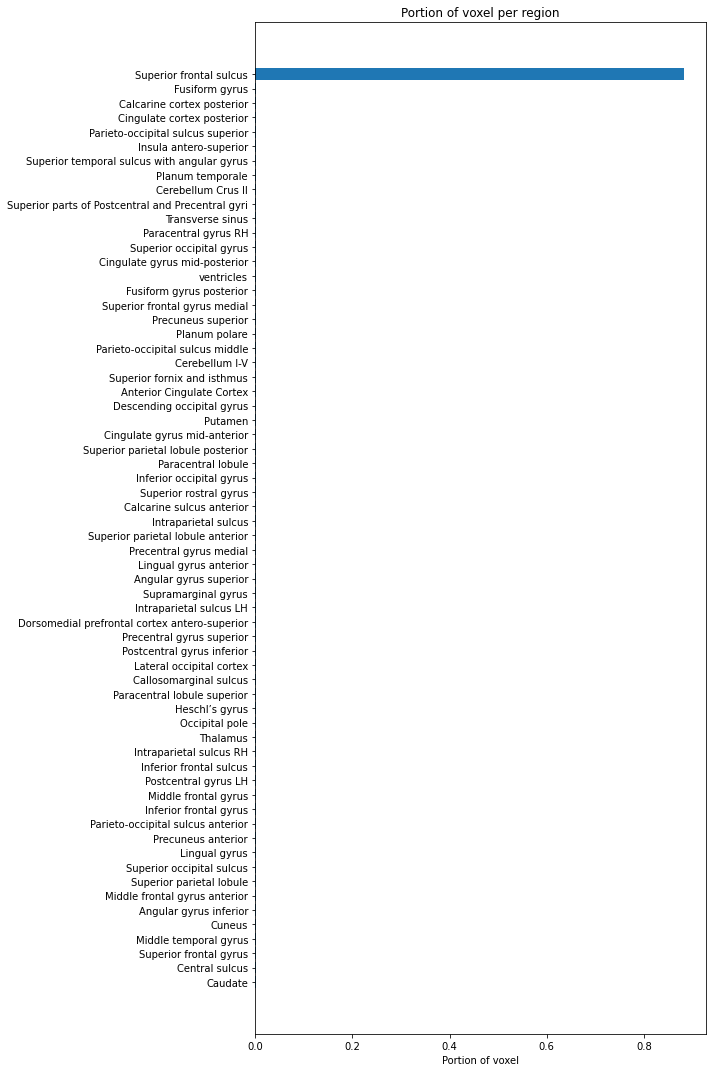

In [15]:
import matplotlib.pyplot as plt
from collections import Counter
# Compute the frequencies
c = list(Counter(get_data(maps).ravel()).values())
freq = [_/np.prod(maps.shape) for _ in c]

fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
y_pos = np.arange(len(labels))
ax.barh(y_pos, freq, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Portion of voxel')
ax.set_title('Portion of voxel per region')
plt.tight_layout()

**Work-around**

I'm pretty sure there are better approaches, but here I will simply associate all voxels having a max of 0 along the last dimension to the "background":

In [16]:
# All voxel having only zeros along last dimension
background_mask = np.max(difumo64_data, axis=-1) == 0.0
assert background_mask.shape == maps.shape

In [17]:
# Increment all label of the maps
maps_3D += 1
# Label all "background" voxel with label 0
maps_3D[background_mask] = 0
np.unique(maps_3D)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

Redoing the plot above with the number of voxels per region:

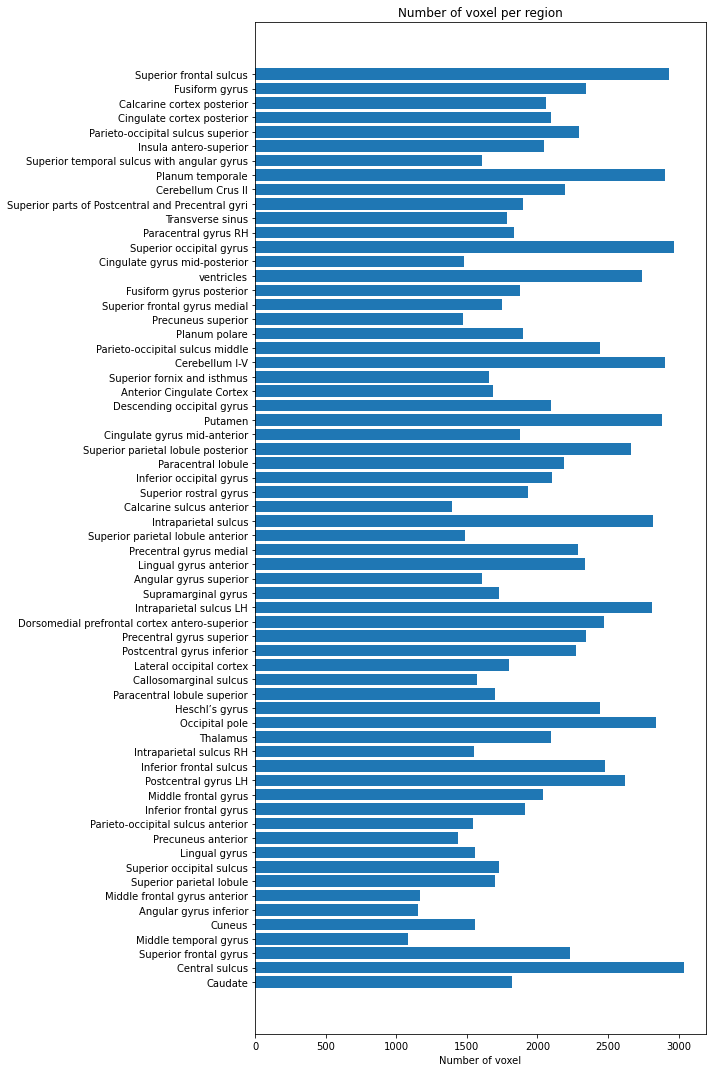

In [18]:
c = list(Counter(maps_3D.ravel()).values())[1:]
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
y_pos = np.arange(len(labels))
ax.barh(y_pos, c, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of voxel')
ax.set_title('Number of voxel per region')
plt.tight_layout()

## Step 3: Extract signals from the regions

We can now extract signals from the regions using the `NiftiLabelsMasker`:

In [19]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import new_img_like

# Build a maps out of the array we computed above
new_maps = new_img_like(maps, maps_3D)

# Use NiftiLabelsMasker to extract signals from regions
masker = NiftiLabelsMasker(labels_img=new_maps, 
                           standardize=True)

time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, 
                                            confounds=confounds))
time_series = np.array(time_series)
time_series.shape

(10, 168, 64)

We have 64 standardized time series of length 168 per subject (10 subjects were loaded). 

We can plot them if needed:

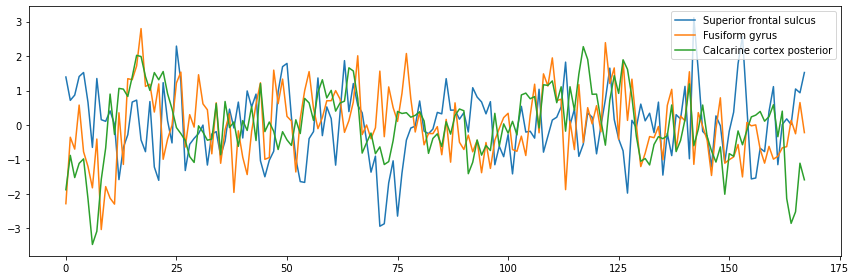

In [20]:
fig = plt.figure(figsize=(12,4))
for i in [0,1,2]:
    plt.plot(time_series[0,:,i], label=labels[i])
plt.legend()
plt.tight_layout()

## Step 4: Connectivity Analysis

Here we compute the correlation between these time series:

In [21]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(time_series)
assert correlation_matrix.shape == (10, 64, 64)

In order to visualize this matrix, we take the mean accross subject:

In [22]:
mean_correlation_matrix = correlation_measure.mean_
assert mean_correlation_matrix.shape == (64, 64)

## Step 5: Plot the results

We can plot the matrix with the region names:

/home/nicolas/anaconda3/envs/brainscapes/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:22: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ylabel_width = ax.yaxis.get_tightbbox(renderer).inverse_transformed(
/home/nicolas/anaconda3/envs/brainscapes/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:30: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  xlabel_height = ax.xaxis.get_tightbbox(renderer).inverse_transformed(


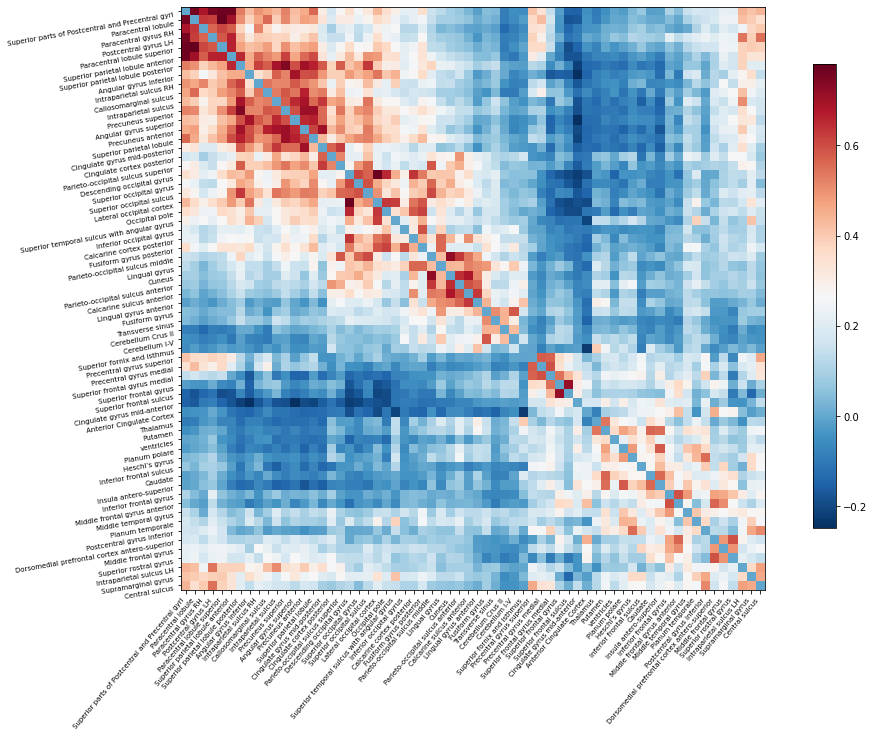

In [23]:
from nilearn.plotting import plot_matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(mean_correlation_matrix, 0)
# matrices are ordered for block-like representation
plot_matrix(mean_correlation_matrix, 
            figure=(12, 12), 
            labels=labels, 
            reorder=True)

Finally, we can plot the connectome as a graph:

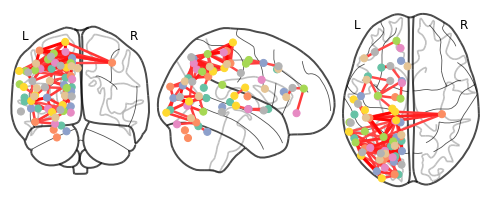

In [24]:
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

# grab center coordinates for atlas labels
coordinates = find_parcellation_cut_coords(labels_img=new_maps)

# plot connectome with 95% edge strength in the connectivity
plot_connectome(mean_correlation_matrix, 
                coordinates,
                edge_threshold="95%")